In [1]:
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import patsy
import statsmodels.api as sm 
import statsmodels.formula.api as smf
import numpy as np 
from pandas_datareader import data, wb   #read data from FRED data
import datetime as dt
import functools as ft

First of all, I will load and clean the data for different main economic data for those three countries, including Quarterly GDP, monthly unemployment rate, daily foreign exchange rate, monthly foreign reserves, and short-term interest rate from 1997-2018. The data sources are mainly from FRED data, IMF and National Bureau Statistics of China. 


Note: I will mainly use the GDP growth for those three countries to eliminate the currency differences among those countries and to make the analysis more consistent. In addition, there are some inconsistencies of the data collection because some data of China is missing or not recorded.

In [2]:
#import monthly reserve data, in dollars for three countries from FRED
start = dt.datetime(1996, 12, 1) 
chn_rev = data.DataReader(['TRESEGCNM052N'], 'fred', start)
chn_rev=chn_rev.rename(columns={'TRESEGCNM052N':'reserves'})
jpn_rev=data.DataReader(['TRESEGJPM052N'], 'fred', start)
jpn_rev=jpn_rev.rename(columns={'TRESEGJPM052N':'reserves'})
sk_rev=data.DataReader(['TRESEGKRM052N'], 'fred', start)
sk_rev=sk_rev.rename(columns={'TRESEGKRM052N':'reserves'})
#get the growth rate of foreign reserve to keep all data consistent in graphs
chn_rev['rev_pct'] = chn_rev['reserves'].pct_change() 
jpn_rev['rev_pct'] = jpn_rev['reserves'].pct_change()
sk_rev['rev_pct'] = sk_rev['reserves'].pct_change()
chn_rev.head()

,reserves,rev_pct
DATE,,
1996-12-01,1.070394e+11,NaN
1997-01-01,1.106289e+11,0.033534
1997-02-01,1.122194e+11,0.014377
1997-03-01,1.139621e+11,0.015529
1997-04-01,1.162857e+11,0.020389


In [3]:
#daily foreign exchange rate for three countries from FRED
start = dt.datetime(1997, 1, 1) 
chn_fx = data.DataReader(['DEXCHUS'], 'fred', start) #Chinese Yuan to One U.S. Dollar
chn_fx=chn_fx.rename(columns={'DEXCHUS':'FX'}) 
chn_fx_m=chn_fx.resample('m').mean()               #get monthly fx rate
jpn_fx=data.DataReader(['DEXJPUS'], 'fred', start) #Japanese Yen to One U.S. Dollar
jpn_fx=jpn_fx.rename(columns={'DEXJPUS':'FX'})
jpn_fx_m=jpn_fx.resample('m').mean()               #get monthly fx rate
sk_fx=data.DataReader(['DEXKOUS'], 'fred', start) #South Korean Won to One U.S. Dollar
sk_fx=sk_fx.rename(columns={'DEXKOUS':'FX'})
sk_fx_m=sk_fx.resample('m').mean()               #get monthly fx rate for dataset

In [4]:
#quarterly Japan real GDP from FRED, in billions yen, 1997/01/01 is the earliest 
jpn_gdp=data.DataReader(['JPNRGDPEXP'], 'fred', start)
jpn_gdp=jpn_gdp.rename(columns={'JPNRGDPEXP':'RGDP'})
jpn_gdp['RGDP_g'] = jpn_gdp['RGDP'].pct_change() #get real GDP growth rate for Japan 

In [5]:
#Quarterly real GDP of Korea from IMF, in million won
sk_gdp=pd.read_excel('KoreaRGDP.xlsx',header=1)
sk_gdp=sk_gdp.set_index('DATE')
sk_gdp=sk_gdp.transpose()
sk_gdp=sk_gdp.rename(columns={'National Accounts, Expenditure, Gross Domestic Product, Real, Spliced Historical Series, Domestic Currency':'RGDP'})
sk_gdp=sk_gdp.loc[~sk_gdp['RGDP'].isin(['M'])]
def convert(date): #reformat the strings to convert the data into datetime object
    date=date[3:]+date[0]+date[1]
    return date
sk_gdp.index=sk_gdp.index.map(convert)
sk_gdp.index=pd.to_datetime(sk_gdp.index)
sk_gdp['RGDP_g']=sk_gdp['RGDP'].pct_change() #get real GDP growth rate for Korea

In [6]:
#quarterly china nominal gdp from National Bureau Statistics of China, in 100 million yuan
chn_gdp=pd.read_csv('China_GDP.csv',encoding="ISO-8859-1", header=2)
chn_gdp=chn_gdp.rename(columns={'Indicators':'DATE'})
chn_gdp.set_index('DATE',inplace=True)
chn_gdp=chn_gdp.transpose()
#drop all the columns that I don't need, only keep china nominal GDP
chn_gdp=chn_gdp.loc[:,chn_gdp.columns.isin(['Indicators','Gross Domestic Product Current Quarter(100 million yuan)'])]
chn_gdp=chn_gdp.rename(columns={'Gross Domestic Product Current Quarter(100 million yuan)':'NGDP'})
def convert(date): #reformat the strings to convert the data into datetime object
    date=date[3:]+date[1]+date[0]
    return date
chn_gdp.index=chn_gdp.index.map(convert)
chn_gdp.index=pd.to_datetime(chn_gdp.index) #get nominal GDP growth rate for China
chn_gdp['NGDP_g']=chn_gdp['NGDP'].pct_change()
chn_gdp=chn_gdp.sort_index()
chn_gdp.head()

DATE,NGDP,NGDP_g
1997-01-01,16689.1,-0.129125
1997-04-01,19163.6,-0.065231
1997-07-01,20500.9,-0.122449
1997-10-01,23361.5,0.294330
1998-01-01,18049.1,-0.110733


In [7]:
#quarterly unemployment rate for three countries from IMF, china starts to have record in 2002
um=pd.read_excel('um.xlsx',header=1)
um=um.rename(columns={'Country':'Date'})
um=um.set_index('Date')
um=um.transpose()
um=um.loc[~um['Japan'].isin(['NAN'])]
def convertimf(date):
    date=date[3:]+date[0]+date[1]
    return date
um.index=um.index.map(convertimf)
um=um.rename(columns={'China, P.R.: Mainland':'CUM','Japan':'JUM','Korea, Republic of':'KUM'}) #CUM: China Unemployment Rate
um.index=pd.to_datetime(um.index)
um.head()

Date,CUM,JUM,KUM
1997-01-01,NaN,3.433333,3.066667
1997-04-01,NaN,3.400000,2.533333
1997-07-01,NaN,3.400000,2.166667
1997-10-01,NaN,3.366667,2.600000
1998-01-01,NaN,3.800000,5.633333


In [8]:
#monthly short-term interest rate
chn_ir= data.DataReader(['INTDSRCNM193N'], 'fred', start)
chn_ir=chn_ir.rename(columns={'INTDSRCNM193N':'Interest Rate'})
chn_ir_m=chn_ir.resample('m').mean()                            #get monthly short term interest rate
jpn_ir=data.DataReader(['INTDSRJPM193N'], 'fred', start)
jpn_ir=jpn_ir.rename(columns={'INTDSRJPM193N':'Interest Rate'})
jpn_ir_m=jpn_ir.resample('m').mean()                            #get monthly short term interest rate
sk_ir=data.DataReader(['INTDSRKRM193N'], 'fred', start)
sk_ir=sk_ir.rename(columns={'INTDSRKRM193N':'Interest Rate'})
sk_ir_m=sk_ir.resample('m').mean()                            #get monthly short term interest rate

In [9]:
#daily stock index from Yahoo Finance 
#daily stock index for china
chn_sm=pd.read_csv('SHSE.csv')
chn_sm['Date']=pd.to_datetime(chn_sm['Date'])
chn_sm=chn_sm.drop(['Open','High','Low','Adj Close','Volume'],axis=1)
chn_sm=chn_sm.set_index('Date') #this is daily stock price data
chn_sm_m=chn_sm.resample('m').mean() #get monthly stock price to graph
chn_sm_m['close_pct']=chn_sm_m['Close'].pct_change() #get changes in stock price
#daily stock index for korea
sk_sm=pd.read_csv('KOSPI.csv')
sk_sm['Date']=pd.to_datetime(sk_sm['Date'])
sk_sm=sk_sm.drop(['Open','High','Low','Adj Close','Volume'],axis=1)
sk_sm=sk_sm.set_index('Date') #this is daily stock price data
sk_sm_m=sk_sm.resample('m').mean() #get monthly stock price to graph, the korean data started at July 
sk_sm_m['close_pct']=sk_sm_m['Close'].pct_change() #get changes in stock price
#daily stock index for japan
jpn_sm=pd.read_csv('^N225.csv')
jpn_sm['Date']=pd.to_datetime(jpn_sm['Date'])
jpn_sm=jpn_sm.drop(['Open','High','Low','Adj Close','Volume'],axis=1)
jpn_sm=jpn_sm.set_index('Date') #this is daily stock price data
jpn_sm_m=jpn_sm.resample('m').mean() #get monthly stock price to graph 
jpn_sm_m['close_pct']=jpn_sm_m['Close'].pct_change() #get changes in stock price
jpn_sm_m.head()

,Close,close_pct
Date,,
1997-01-31,18050.442640,NaN
1997-02-28,18562.511035,0.028369
1997-03-31,18244.074121,-0.017155
1997-04-30,18177.955636,-0.003624
1997-05-31,20045.933036,0.102761


After cleaning the data, I will plot a graph showing the changes of the foreign reserve for those countries from 1997-2018. I will define the duration of Asian financial crisis is 1997/7/1-1999/12/31 and the one of 2008 global financial crisis is 2007/1/1-2009/12/31. The yellow highlighted regions are the financial crisis. 

In [10]:
#to normalize the foreign reserve, importing the annual GDP data from WorldBank
gdp=pd.read_csv('AnnualGDP.csv')
gdp=gdp.set_index('Country Name')
gdp=gdp.transpose()
gdp.index=pd.to_datetime(gdp.index)
gdp=gdp.rename(columns={'China':'cgdp','Japan':'jgdp','Korea, Rep.':'sgdp'})
#resample to annual foreign reserves
chn_rev_a=chn_rev.resample('AS').mean()
chn_rev_a=chn_rev_a.rename(columns={'reserves':'crev','rev_pct':'crev_pct'})
jpn_rev_a=jpn_rev.resample('AS').mean()
jpn_rev_a=jpn_rev_a.rename(columns={'reserves':'jrev','rev_pct':'jrev_pct'})
sk_rev_a=sk_rev.resample('AS').mean()
sk_rev_a=sk_rev_a.rename(columns={'reserves':'srev','rev_pct':'srev_pct'})
#merge three datasets to get the reserve in percentage of GDP
rev=ft.reduce(ft.partial(pd.merge,on='DATE'), [chn_rev_a,sk_rev_a,jpn_rev_a])
rev_gdp=pd.merge(rev,gdp,left_index=True,right_index=True)
a=['c','s','j']
for elm in a: #rename the column to make data for three different countries more readable 
    val1=elm+'rev'
    val2=elm+'gdp'
    col=val1+'_gdp'
    rev_gdp[col]=(rev_gdp[val1]/rev_gdp[val2])*100
    
rev_gdp.head()

,crev,crev_pct,srev,srev_pct,jrev,jrev_pct,cgdp,jgdp,sgdp,crev_gdp,srev_gdp,jrev_gdp
1997-01-01,1.262875e+11,0.024334,2.997108e+10,-0.038794,2.211447e+11,0.001210,9.616040e+11,4.414730e+12,5.575030e+11,13.133009,5.375949,5.009246
1998-01-01,1.451956e+11,0.003690,4.003635e+10,0.082433,2.123771e+11,-0.001291,1.029040e+12,4.032510e+12,3.742410e+11,14.109814,10.698012,5.266622
1999-01-01,1.527834e+11,0.004659,6.279379e+10,0.030035,2.478322e+11,0.024659,1.094000e+12,4.562080e+12,4.852480e+11,13.965575,12.940556,5.432438
2000-01-01,1.619921e+11,0.005421,8.812708e+10,0.022177,3.298182e+11,0.018154,1.211350e+12,4.887520e+12,5.616330e+11,13.372856,15.691222,6.748170
2001-01-01,1.906849e+11,0.020928,9.723950e+10,0.005635,3.704198e+11,0.009173,1.339400e+12,4.303540e+12,5.330520e+11,14.236593,18.242029,8.607329


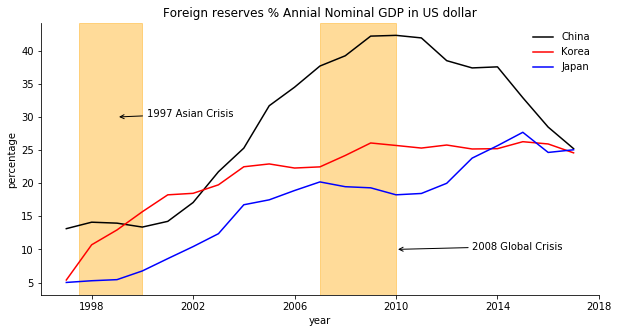

In [11]:
#Changes of foreign reserves for three countries 
fig, ax = plt.subplots(figsize=(10,5)) 
ax.plot(rev_gdp.index, rev_gdp.crev_gdp,color='black', label = 'China')    
ax.plot(rev_gdp.index, rev_gdp.srev_gdp,        
        color='red', label='Korea' )  
ax.plot(rev_gdp.index, rev_gdp.jrev_gdp,        
        color='blue', label='Japan')  
ax.set_ylabel('percentage')  
ax.set_xlabel('year')                 
ax.set_title('Foreign reserves % Annial Nominal GDP in US dollar')
ax.spines['right'].set_visible(False) 
ax.spines['top'].set_visible(False)
ax.legend(frameon=False, loc='upper right')
ax.axvspan(dt.datetime(1997,7,1),dt.datetime(1999,12,31),color='orange',alpha=0.4)
ax.axvspan(dt.datetime(2007,1,1),dt.datetime(2009,12,31),color='orange',alpha=0.4)
ax.annotate('1997 Asian Crisis', xy=(dt.datetime(1999,1,1), 30), xytext=(dt.datetime(2000,3,1), 30),arrowprops=dict(facecolor='black', arrowstyle='->'),)
ax.annotate('2008 Global Crisis', xy=(dt.datetime(2010,1,1), 10), xytext=(dt.datetime(2013,1,1), 10),arrowprops=dict(facecolor='black', arrowstyle='->'),)
fig.savefig('foriegnrev.png')

As you can see, after the 1997 Asian financial crisis, the foreign resevres of those countries have significantly increased over the years and kept increasing even after 2008 fianncial crisis. Next, I will dive into plotting the overall economic performance of each country. To compared the effect of increase in foreign reserve, I will compare the performance of each economic indicator during 1997 Asian financial crisis and the 2008 global financial crisis through graph and standard deviation. 

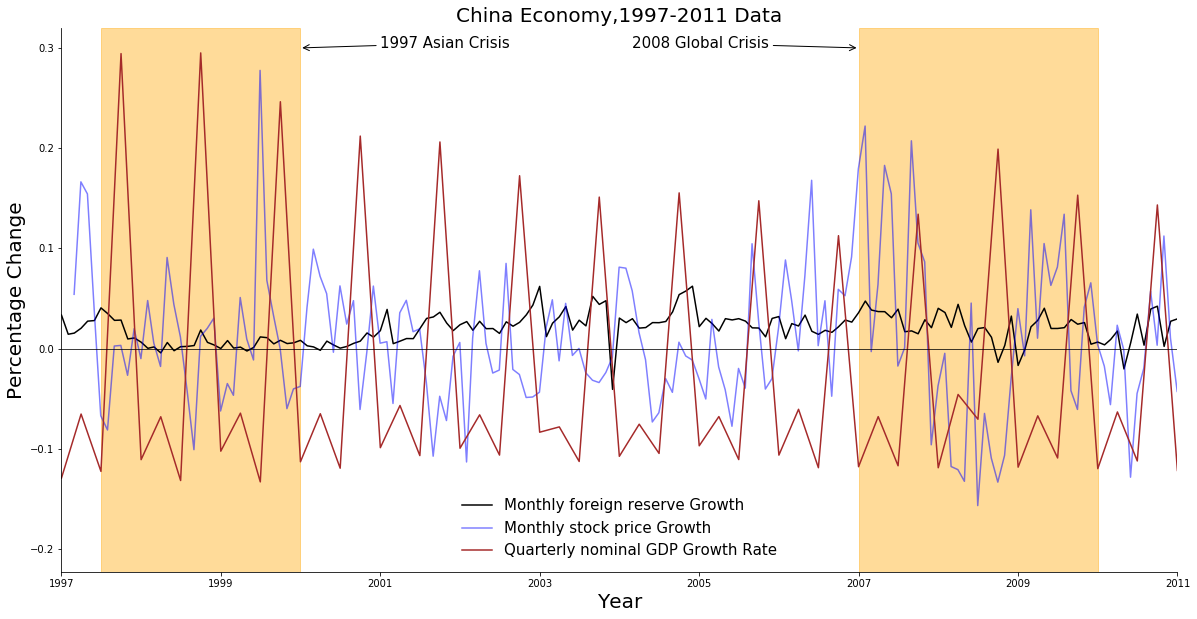

In [12]:
#China Plotting
fig, ax = plt.subplots(figsize=(20,10)) 
ax.plot(chn_rev.index, chn_rev['rev_pct'],        
        color='black',                  
       label = 'Monthly foreign reserve Growth'
       )  
ax.plot(chn_sm_m.index, chn_sm_m['close_pct'],        
        color='blue',                  
       label = 'Monthly stock price Growth',alpha=0.5
       )
ax.plot(chn_gdp.index, chn_gdp['NGDP_g'],        
        color='brown',                  
       label = 'Quarterly nominal GDP Growth Rate'
       )
ax.set_title('China Economy,1997-2011 Data',fontsize=20)
ax.set_ylabel('Percentage Change',fontsize=20)
ax.set_xlabel('Year',fontsize=20)
ax.spines['right'].set_visible(False) 
ax.spines['top'].set_visible(False)   
ax.set_xlim(dt.datetime(1997,1,1),dt.datetime(2011,1,1))
ax.axhline(y=0,color='black',linewidth=0.75)
ax.legend(frameon=False, loc='best',fontsize=15)
ax.axvspan(dt.datetime(1997,7,1),dt.datetime(1999,12,31),color='orange',alpha=0.4)
ax.axvspan(dt.datetime(2007,1,1),dt.datetime(2009,12,31),color='orange',alpha=0.4)
ax.annotate('1997 Asian Crisis', xy=(dt.datetime(1999,12,31), 0.3), xytext=(dt.datetime(2000,12,31), 0.3),arrowprops=dict(facecolor='black', arrowstyle='->'),fontsize=15)
ax.annotate('2008 Global Crisis',xy=(dt.datetime(2007,1,1), 0.3),xytext=(dt.datetime(2004,3,1), 0.3),arrowprops=dict(facecolor='black', arrowstyle='->'), fontsize=15)
fig.savefig('chinaeconomy.png')    

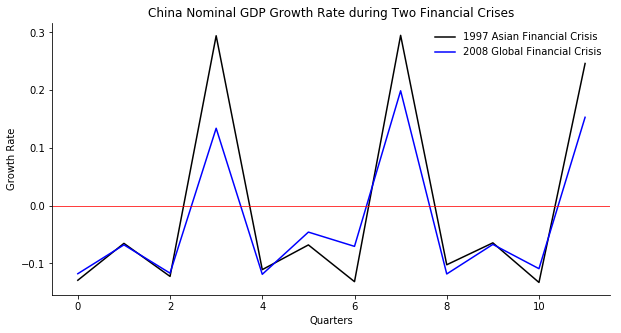

In [13]:
#compare between 1997 and 2008 financial crisis for each China economic indicator:
        #Nominal GDP, foreign exchange rate, short-term interest rate, and percent changes in stock prices
# nominal GDP quarterly growth rate for China:
start_date_97=dt.datetime(1997,1,1)
end_date_97=dt.datetime(1999,12,31)
mask_97 = (chn_gdp.index >= start_date_97) & (chn_gdp.index <= end_date_97) #only get the data for 1997 financial crisis
chn_gdp_97=chn_gdp.loc[mask_97]
chn_gdp_97=chn_gdp_97.reset_index()
start_date_08=dt.datetime(2007,1,1)
end_date_08=dt.datetime(2009,12,31)
mask_08 = (chn_gdp.index>= start_date_08) & (chn_gdp.index <= end_date_08) #only get the data for 2008 financial crisis
chn_gdp_08=chn_gdp.loc[mask_08]
chn_gdp_08=chn_gdp_08.reset_index()
fig, ax = plt.subplots(figsize=(10,5)) 
ax.plot(chn_gdp_97.index, chn_gdp_97['NGDP_g'],color='black', label = '1997 Asian Financial Crisis')    
ax.plot(chn_gdp_08.index, chn_gdp_08['NGDP_g'],color='blue', label = '2008 Global Financial Crisis')
ax.set_ylabel('Growth Rate')  
ax.set_xlabel('Quarters')                 
ax.set_title('China Nominal GDP Growth Rate during Two Financial Crises')
ax.spines['right'].set_visible(False) 
ax.spines['top'].set_visible(False)
ax.legend(frameon=False, loc='upper right')
ax.axhline(y=0,color='red',linewidth=0.75)
fig.savefig('cgdpgrowth.png')

In [14]:
print(chn_gdp_97.describe()) #to show the statistics,mainly standard deviation of the indicator
print(chn_gdp_08.describe())

DATE           NGDP     NGDP_g
count     12.000000  12.000000
mean   21289.575000  -0.007571
std     2885.234838   0.174779
min    16689.100000  -0.132904
25%    19312.325000  -0.124118
50%    21034.300000  -0.085097
75%    23128.475000   0.013325
max    26583.900000   0.295028
DATE            NGDP     NGDP_g
count      12.000000  12.000000
mean    78235.766667  -0.028777
std     12124.339381   0.118618
min     57177.000000  -0.118811
25%     69495.825000  -0.117066
50%     78745.200000  -0.069114
75%     85184.550000  -0.000746
max    101032.800000   0.199063


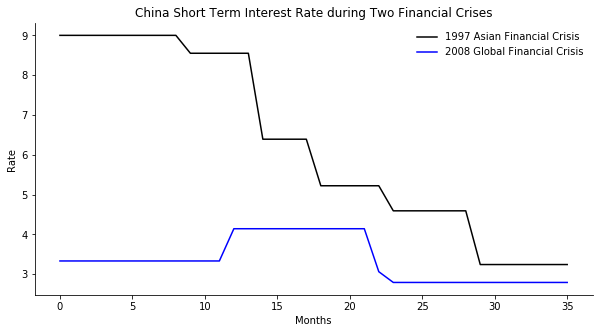

In [15]:
#monthly short-term interest rate for China: 
start_date_97=dt.datetime(1997,1,1)
end_date_97=dt.datetime(1999,12,31)
mask_97 = (chn_ir_m.index>= start_date_97) & (chn_ir_m.index <= end_date_97)
chn_ir_97=chn_ir_m.loc[mask_97]
chn_ir_97=chn_ir_97.reset_index()
start_date_08=dt.datetime(2007,1,1)
end_date_08=dt.datetime(2009,12,31)
mask_08 = (chn_ir_m.index>= start_date_08) & (chn_ir_m.index <= end_date_08)
chn_ir_08=chn_ir_m.loc[mask_08]
chn_ir_08=chn_ir_08.reset_index()
fig, ax = plt.subplots(figsize=(10,5)) 
ax.plot(chn_ir_97.index, chn_ir_97['Interest Rate'],color='black', label = '1997 Asian Financial Crisis')    
ax.plot(chn_ir_08.index, chn_ir_08['Interest Rate'],color='blue', label = '2008 Global Financial Crisis')
ax.set_ylabel('Rate')  
ax.set_xlabel('Months')                 
ax.set_title('China Short Term Interest Rate during Two Financial Crises')
ax.spines['right'].set_visible(False) 
ax.spines['top'].set_visible(False)
ax.legend(frameon=False)
fig.savefig('cinterestrate.png')

In [16]:
print(chn_ir_97.describe())
print(chn_ir_08.describe())

       Interest Rate
count       36.00000
mean         6.26750
std          2.26677
min          3.24000
25%          4.59000
50%          5.80500
75%          8.66250
max          9.00000
       Interest Rate
count      36.000000
mean        3.352500
std         0.545278
min         2.790000
25%         2.790000
50%         3.330000
75%         4.140000
max         4.140000


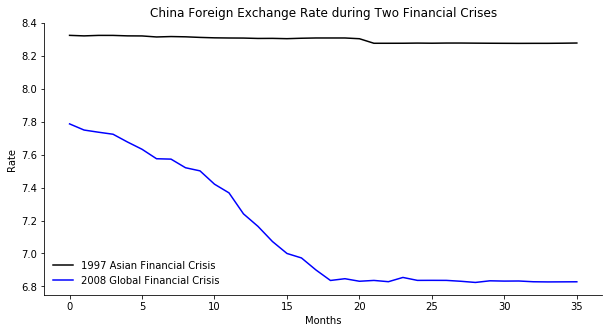

In [17]:
#monthly foreign exchange rate interest rate for China: 
start_date_97=dt.datetime(1997,1,1)
end_date_97=dt.datetime(1999,12,31)
mask_97 = (chn_fx_m.index>= start_date_97) & (chn_fx_m.index <= end_date_97)
chn_fx_97=chn_fx_m.loc[mask_97]
chn_fx_97=chn_fx_97.reset_index()
start_date_08=dt.datetime(2007,1,1)
end_date_08=dt.datetime(2009,12,31)
mask_08 = (chn_fx_m.index>= start_date_08) & (chn_fx_m.index <= end_date_08)
chn_fx_08=chn_fx_m.loc[mask_08]
chn_fx_08=chn_fx_08.reset_index()
fig, ax = plt.subplots(figsize=(10,5)) 
ax.plot(chn_fx_97.index, chn_fx_97['FX'],color='black', label = '1997 Asian Financial Crisis')    
ax.plot(chn_fx_08.index, chn_fx_08['FX'],color='blue', label = '2008 Global Financial Crisis')
ax.set_ylabel('Rate')  
ax.set_xlabel('Months')                 
ax.set_title('China Foreign Exchange Rate during Two Financial Crises')
ax.spines['right'].set_visible(False) 
ax.spines['top'].set_visible(False)
ax.legend(frameon=False)
fig.savefig('cfxrate.png')

In [18]:
print(chn_fx_97.describe())
print(chn_fx_08.describe())

              FX
count  36.000000
mean    8.299396
std     0.018972
min     8.277245
25%     8.278203
50%     8.307385
75%     8.314160
max     8.325967
              FX
count  36.000000
mean    7.128292
std     0.363208
min     6.823480
25%     6.832123
50%     6.876610
75%     7.506682
max     7.787624


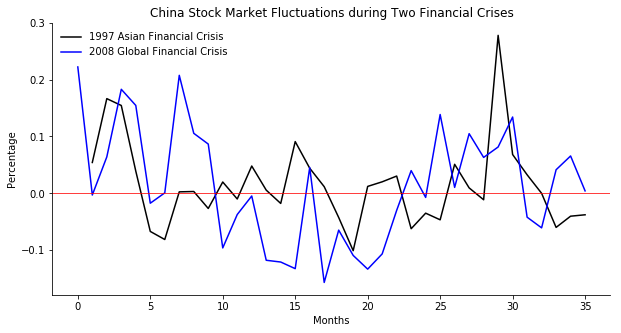

In [19]:
#monthly stock market fluctiations in China: 
start_date_97=dt.datetime(1997,1,1)
end_date_97=dt.datetime(1999,12,31)
mask_97 = (chn_sm_m.index>= start_date_97) & (chn_sm_m.index <= end_date_97)
chn_sm_97=chn_sm_m.loc[mask_97]
chn_sm_97=chn_sm_97.reset_index()
start_date_08=dt.datetime(2007,1,1)
end_date_08=dt.datetime(2009,12,31)
mask_08 = (chn_sm_m.index>= start_date_08) & (chn_sm_m.index <= end_date_08)
chn_sm_08=chn_sm_m.loc[mask_08]
chn_sm_08=chn_sm_08.reset_index()
fig, ax = plt.subplots(figsize=(10,5)) 
ax.plot(chn_sm_97.index, chn_sm_97['close_pct'],color='black', label = '1997 Asian Financial Crisis')    
ax.plot(chn_sm_08.index, chn_sm_08['close_pct'],color='blue', label = '2008 Global Financial Crisis')
ax.set_ylabel('Percentage')  
ax.set_xlabel('Months')                 
ax.set_title('China Stock Market Fluctuations during Two Financial Crises')
ax.axhline(y=0,color='red',linewidth=0.75)
ax.spines['right'].set_visible(False) 
ax.spines['top'].set_visible(False)
ax.legend(frameon=False)
fig.savefig('csmprice.png')

In [20]:
print(chn_sm_97.describe())
print(chn_sm_08.describe())

             Close  close_pct
count    36.000000  35.000000
mean   1262.898454   0.014406
std     162.145526   0.074134
min     927.321732  -0.100763
25%    1160.296480  -0.036247
50%    1210.275502   0.005634
75%    1367.266426   0.041579
max    1617.212036   0.277569
             Close  close_pct
count    36.000000  36.000000
mean   3336.365669   0.014299
std    1081.789701   0.102305
min    1876.015216  -0.156540
25%    2587.047433  -0.061632
50%    3042.140811   0.002582
75%    4013.485968   0.082718
max    5824.120334   0.222061


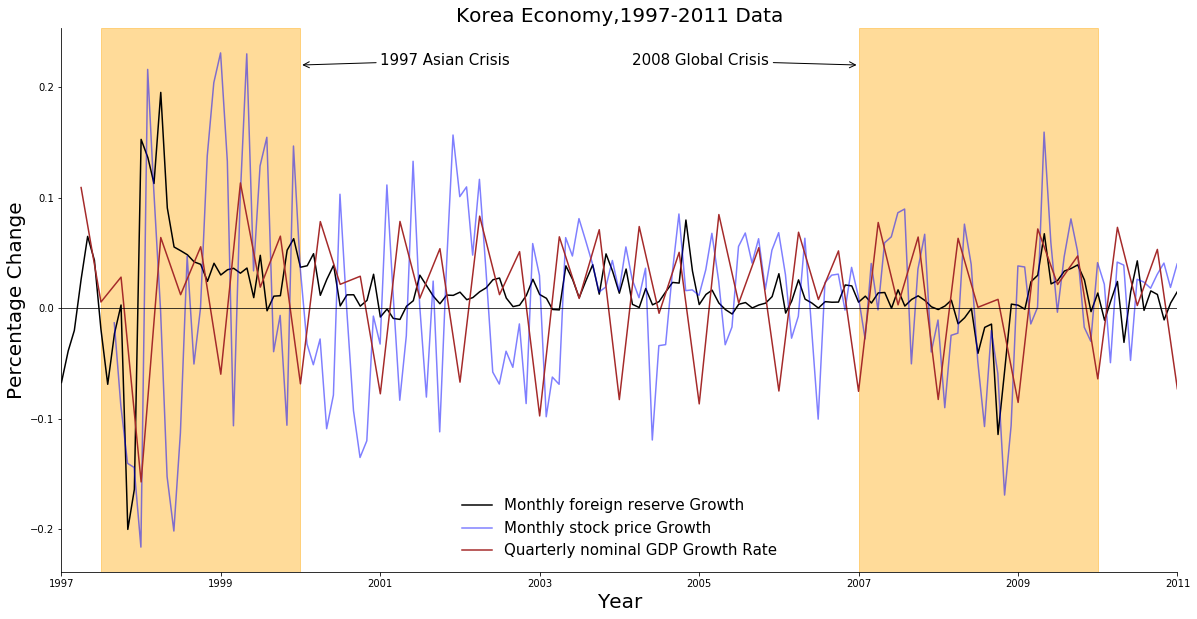

In [21]:
#In the case of Korea:
fig1, ax1 = plt.subplots(figsize=(20,10)) 
ax1.plot(sk_rev.index, sk_rev['rev_pct'],        
        color='black',                  
       label = 'Monthly foreign reserve Growth'
       )  
ax1.plot(sk_sm_m.index, sk_sm_m['close_pct'],        
        color='blue',                  
       label = 'Monthly stock price Growth',alpha=0.5
       )
ax1.plot(sk_gdp.index, sk_gdp['RGDP_g'],        
        color='brown',                  
       label = 'Quarterly nominal GDP Growth Rate'
       )
ax1.set_title('Korea Economy,1997-2011 Data',fontsize=20)
ax1.set_ylabel('Percentage Change',fontsize=20)
ax1.set_xlabel('Year',fontsize=20)
ax1.spines['right'].set_visible(False) 
ax1.spines['top'].set_visible(False)   
ax1.set_xlim(dt.datetime(1997,1,1),dt.datetime(2011,1,1))
ax1.axhline(y=0,color='black',linewidth=0.75)
ax1.legend(frameon=False, loc='best',fontsize=15)
ax1.axvspan(dt.datetime(1997,7,1),dt.datetime(1999,12,31),color='orange',alpha=0.4)
ax1.axvspan(dt.datetime(2007,1,1),dt.datetime(2009,12,31),color='orange',alpha=0.4)
ax1.annotate('1997 Asian Crisis', xy=(dt.datetime(1999,12,31), 0.22), xytext=(dt.datetime(2000,12,31), 0.22),arrowprops=dict(facecolor='black', arrowstyle='->'),fontsize=15)
ax1.annotate('2008 Global Crisis',xy=(dt.datetime(2007,1,1), 0.22),xytext=(dt.datetime(2004,3,1), 0.22),arrowprops=dict(facecolor='black', arrowstyle='->'), fontsize=15)
fig1.savefig('koreaeconomy.png')

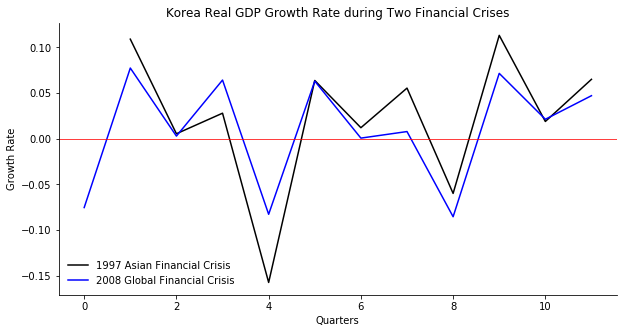

In [22]:
#compare between 1997 and 2008 financial crisis for each Korea economic indicator:
        #Nominal GDP, foreign exchange rate, short-term interest rate, and percent changes in stock prices
# nominal GDP quarterly growth rate for Korea:
start_date_97=dt.datetime(1997,1,1)
end_date_97=dt.datetime(1999,12,31)
mask_97 = (sk_gdp.index>= start_date_97) & (sk_gdp.index <= end_date_97)
sk_gdp_97=sk_gdp.loc[mask_97]
sk_gdp_97=sk_gdp_97.reset_index()
start_date_08=dt.datetime(2007,1,1)
end_date_08=dt.datetime(2009,12,31)
mask_08 = (sk_gdp.index>= start_date_08) & (sk_gdp.index <= end_date_08)
sk_gdp_08=sk_gdp.loc[mask_08]
sk_gdp_08=sk_gdp_08.reset_index()
fig, ax = plt.subplots(figsize=(10,5)) 
ax.plot(sk_gdp_97.index, sk_gdp_97['RGDP_g'],color='black', label = '1997 Asian Financial Crisis')    
ax.plot(sk_gdp_08.index, sk_gdp_08['RGDP_g'],color='blue', label = '2008 Global Financial Crisis')
ax.set_ylabel('Growth Rate')  
ax.set_xlabel('Quarters')                 
ax.set_title('Korea Real GDP Growth Rate during Two Financial Crises')
ax.spines['right'].set_visible(False) 
ax.spines['top'].set_visible(False)
ax.legend(frameon=False)
ax.axhline(y=0,color='red',linewidth=0.75)
fig.savefig('skgdpgrowth.png')

In [23]:
print(sk_gdp_97.describe())
print(sk_gdp_08.describe())

DATE      RGDP_g
count  11.000000
mean    0.023100
std     0.077425
min    -0.157405
25%     0.008794
50%     0.028009
75%     0.064490
max     0.113274
DATE      RGDP_g
count  12.000000
mean    0.009422
std     0.060879
min    -0.085421
25%    -0.018312
50%     0.014617
75%     0.063433
max     0.077471


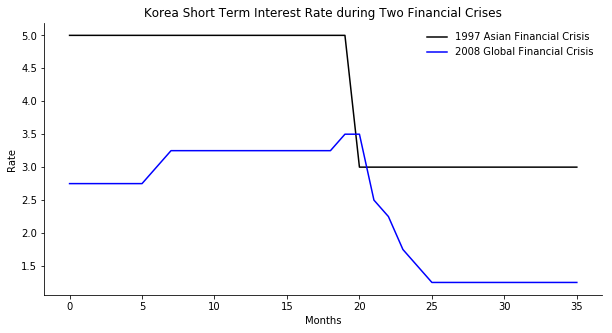

In [24]:
#monthly short-term interest rate for Korea: 
start_date_97=dt.datetime(1997,1,1)
end_date_97=dt.datetime(1999,12,31)
mask_97 = (sk_ir_m.index>= start_date_97) & (sk_ir_m.index <= end_date_97)
sk_ir_97=sk_ir_m.loc[mask_97]
sk_ir_97=sk_ir_97.reset_index()
start_date_08=dt.datetime(2007,1,1)
end_date_08=dt.datetime(2009,12,31)
mask_08 = (sk_ir_m.index>= start_date_08) & (sk_ir_m.index <= end_date_08)
sk_ir_08=sk_ir_m.loc[mask_08]
sk_ir_08=sk_ir_08.reset_index()
fig, ax = plt.subplots(figsize=(10,5)) 
ax.plot(sk_ir_97.index, sk_ir_97['Interest Rate'],color='black', label = '1997 Asian Financial Crisis')    
ax.plot(sk_ir_08.index, sk_ir_08['Interest Rate'],color='blue', label = '2008 Global Financial Crisis')
ax.set_ylabel('Rate')  
ax.set_xlabel('Months')                 
ax.set_title('Korea Short Term Interest Rate during Two Financial Crises')
ax.spines['right'].set_visible(False) 
ax.spines['top'].set_visible(False)
ax.legend(frameon=False)
fig.savefig('skinterestrate.png')

In [25]:
print(sk_ir_97.describe())
print(sk_ir_08.describe())

       Interest Rate
count      36.000000
mean        4.111111
std         1.007905
min         3.000000
25%         3.000000
50%         5.000000
75%         5.000000
max         5.000000
       Interest Rate
count      36.000000
mean        2.423611
std         0.894067
min         1.250000
25%         1.250000
50%         2.750000
75%         3.250000
max         3.500000


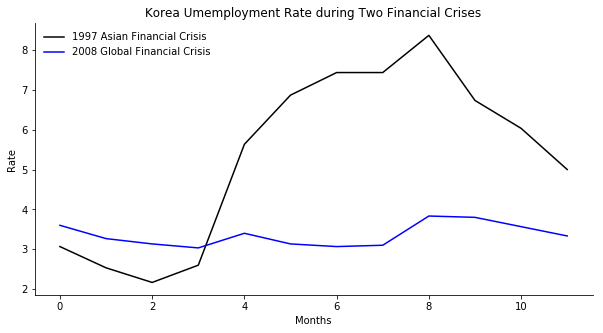

In [26]:
#monthly unemployment rate for Korea: 
start_date_97=dt.datetime(1997,1,1)
end_date_97=dt.datetime(1999,12,31)
mask_97 = (um.index>= start_date_97) & (um.index <= end_date_97)
sk_um_97=um.loc[mask_97]
sk_um_97=sk_um_97.reset_index()
start_date_08=dt.datetime(2007,1,1)
end_date_08=dt.datetime(2009,12,31)
mask_08 = (um.index>= start_date_08) & (um.index <= end_date_08)
sk_um_08=um.loc[mask_08]
sk_um_08=sk_um_08.reset_index()
fig, ax = plt.subplots(figsize=(10,5)) 
ax.plot(sk_um_97.index, sk_um_97['KUM'],color='black', label = '1997 Asian Financial Crisis')    
ax.plot(sk_um_08.index, sk_um_08['KUM'],color='blue', label = '2008 Global Financial Crisis')
ax.set_ylabel('Rate')  
ax.set_xlabel('Months')                 
ax.set_title('Korea Umemployment Rate during Two Financial Crises')
ax.spines['right'].set_visible(False) 
ax.spines['top'].set_visible(False)
ax.legend(frameon=False)
fig.savefig('skumrate.png')

In [27]:
print(sk_um_97.describe())
print(sk_um_08.describe())

Date   CUM        JUM        KUM
count  0.0  12.000000  12.000000
mean   NaN   4.063889   5.322222
std    NaN   0.568083   2.205335
min    NaN   3.366667   2.166667
25%    NaN   3.425000   2.950000
50%    NaN   4.200000   5.833333
75%    NaN   4.491667   7.008333
max    NaN   4.900000   8.366667
Date         CUM        JUM        KUM
count  12.000000  12.000000  12.000000
mean    4.133333   4.294444   3.355556
std     0.137069   0.596595   0.284741
min     4.000000   3.733333   3.033333
25%     4.000000   3.925000   3.125000
50%     4.100000   4.016667   3.300000
75%     4.300000   4.700000   3.575000
max     4.300000   5.400000   3.833333


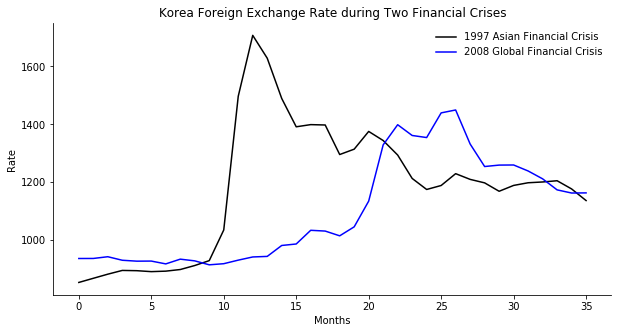

In [28]:
#monthly foreign exchange rate for Korea: 
start_date_97=dt.datetime(1997,1,1)
end_date_97=dt.datetime(1999,12,31)
mask_97 = (sk_fx_m.index>= start_date_97) & (sk_fx_m.index <= end_date_97)
sk_fx_97=sk_fx_m.loc[mask_97]
sk_fx_97=sk_fx_97.reset_index()
start_date_08=dt.datetime(2007,1,1)
end_date_08=dt.datetime(2009,12,31)
mask_08 = (sk_fx_m.index>= start_date_08) & (sk_fx_m.index <= end_date_08)
sk_fx_08=sk_fx_m.loc[mask_08]
sk_fx_08=sk_fx_08.reset_index()
fig, ax = plt.subplots(figsize=(10,5)) 
ax.plot(sk_fx_97.index, sk_fx_97['FX'],color='black', label = '1997 Asian Financial Crisis')    
ax.plot(sk_fx_08.index, sk_fx_08['FX'],color='blue', label = '2008 Global Financial Crisis')
ax.set_ylabel('Rate')  
ax.set_xlabel('Months')                 
ax.set_title('Korea Foreign Exchange Rate during Two Financial Crises')
ax.spines['right'].set_visible(False) 
ax.spines['top'].set_visible(False)
ax.legend(frameon=False)
fig.savefig('skfxrate.png')

In [29]:
print(sk_fx_97.describe())
print(sk_fx_08.describe())

                FX
count    36.000000
mean   1182.802893
std     225.973834
min     854.071429
25%     925.189827
50%    1198.114545
75%    1321.750000
max    1707.300000
                FX
count    36.000000
mean   1101.507668
std     180.001383
min     914.943478
25%     936.192624
50%    1032.809524
75%    1255.582045
max    1449.615909


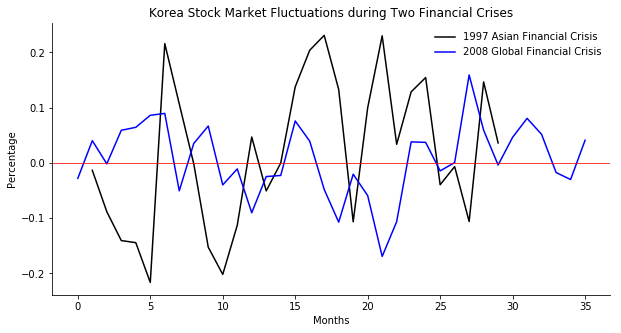

In [30]:
#monthly stock market fluctiations in Korea: 
start_date_97=dt.datetime(1997,1,1)
end_date_97=dt.datetime(1999,12,31)
mask_97 = (sk_sm_m.index>= start_date_97) & (sk_sm_m.index <= end_date_97)
sk_sm_97=sk_sm_m.loc[mask_97]
sk_sm_97=sk_sm_97.reset_index()
start_date_08=dt.datetime(2007,1,1)
end_date_08=dt.datetime(2009,12,31)
mask_08 = (sk_sm_m.index>= start_date_08) & (sk_sm_m.index <= end_date_08)
sk_sm_08=sk_sm_m.loc[mask_08]
sk_sm_08=sk_sm_08.reset_index()
fig, ax = plt.subplots(figsize=(10,5)) 
ax.plot(sk_sm_97.index, sk_sm_97['close_pct'],color='black', label = '1997 Asian Financial Crisis')    
ax.plot(sk_sm_08.index, sk_sm_08['close_pct'],color='blue', label = '2008 Global Financial Crisis')
ax.set_ylabel('Percentage')  
ax.set_xlabel('Months')                 
ax.set_title('Korea Stock Market Fluctuations during Two Financial Crises')
ax.spines['right'].set_visible(False) 
ax.spines['top'].set_visible(False)
ax.legend(frameon=False)
ax.axhline(y=0,color='red',linewidth=0.75)
fig.savefig('sksmprice.png')

In [31]:
print(sk_sm_97.describe())
print(sk_sm_08.describe())

            Close  close_pct
count   30.000000  29.000000
mean   605.106043   0.018071
std    220.375566   0.134794
min    312.233181  -0.216376
25%    431.732548  -0.106061
50%    557.065603  -0.000194
75%    750.148463   0.132988
max    984.483997   0.230981
             Close  close_pct
count    36.000000  36.000000
mean   1557.815120   0.006323
std     256.557601   0.066441
min    1073.944986  -0.169276
25%    1399.184220  -0.028436
50%    1579.760067  -0.000530
75%    1755.255377   0.053528
max    2004.551369   0.159273


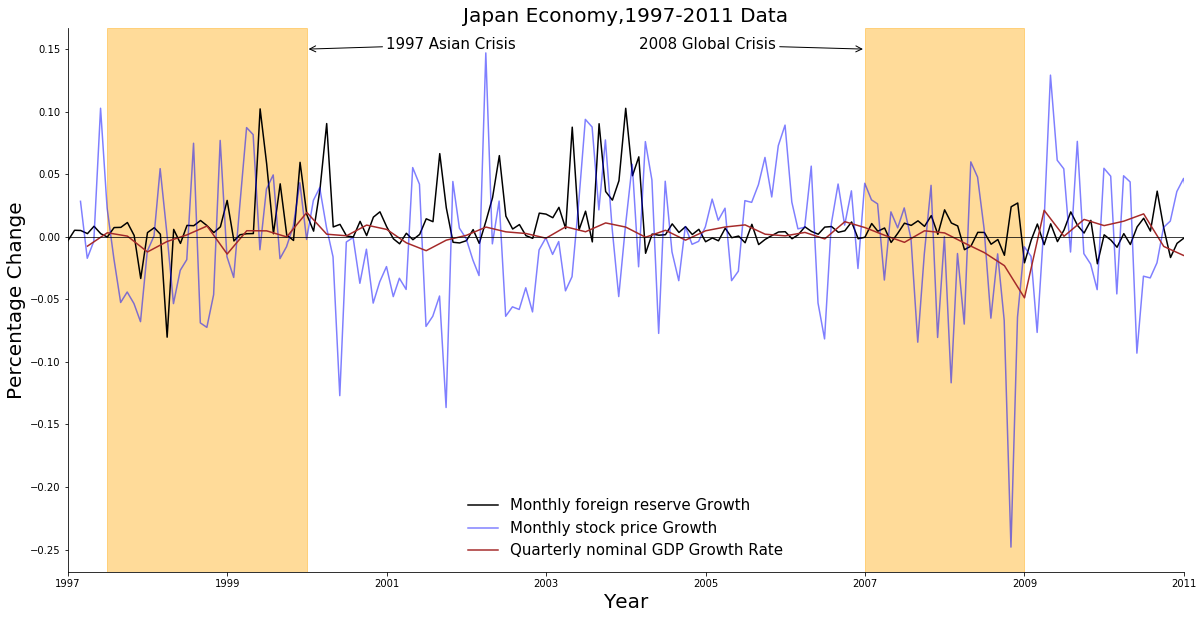

In [32]:
#In the case of Japan:
fig1, ax1 = plt.subplots(figsize=(20,10)) 
ax1.plot(jpn_rev.index, jpn_rev['rev_pct'],        
        color='black',                  
       label = 'Monthly foreign reserve Growth'
       )  
ax1.plot(jpn_sm_m.index, jpn_sm_m['close_pct'],        
        color='blue',                  
       label = 'Monthly stock price Growth',alpha=0.5
       )
ax1.plot(jpn_gdp.index, jpn_gdp['RGDP_g'],        
        color='brown',                  
       label = 'Quarterly nominal GDP Growth Rate'
       )
ax1.set_title('Japan Economy,1997-2011 Data',fontsize=20)
ax1.set_ylabel('Percentage Change',fontsize=20)
ax1.set_xlabel('Year',fontsize=20)
ax1.spines['right'].set_visible(False) 
ax1.spines['top'].set_visible(False)   
ax1.set_xlim(dt.datetime(1997,1,1),dt.datetime(2011,1,1))
ax1.axhline(y=0,color='black',linewidth=0.75)
ax1.legend(frameon=False, loc='best',fontsize=15)
ax1.axvspan(dt.datetime(1997,7,1),dt.datetime(1999,12,31),color='orange',alpha=0.4)
ax1.axvspan(dt.datetime(2007,1,1),dt.datetime(2008,12,31),color='orange',alpha=0.4)
ax1.annotate('1997 Asian Crisis', xy=(dt.datetime(1999,12,31), 0.15), xytext=(dt.datetime(2000,12,31), 0.15),arrowprops=dict(facecolor='black', arrowstyle='->'),fontsize=15)
ax1.annotate('2008 Global Crisis',xy=(dt.datetime(2007,1,1), 0.15),xytext=(dt.datetime(2004,3,1), 0.15),arrowprops=dict(facecolor='black', arrowstyle='->'), fontsize=15)
fig1.savefig('jpneconomy.png')

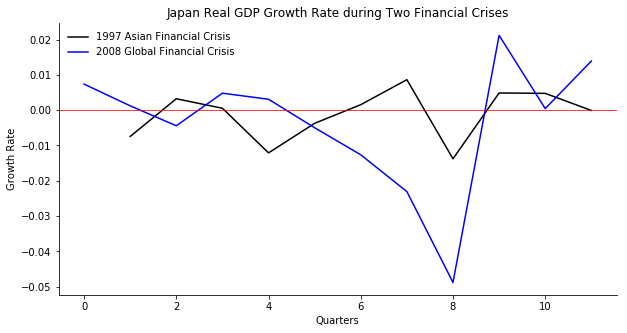

In [33]:
#compare between 1997 and 2008 financial crisis for each Japan economic indicator:
        #Nominal GDP, foreign exchange rate, short-term interest rate, and percent changes in stock prices
# Quarterly Real GDP Data for Japan:
start_date_97=dt.datetime(1997,1,1)
end_date_97=dt.datetime(1999,12,31)
mask_97 = (jpn_gdp.index>= start_date_97) & (jpn_gdp.index <= end_date_97)
jpn_gdp_97=jpn_gdp.loc[mask_97]
jpn_gdp_97=jpn_gdp_97.reset_index()
start_date_08=dt.datetime(2007,1,1)
end_date_08=dt.datetime(2009,12,31)
mask_08 = (jpn_gdp.index>= start_date_08) & (jpn_gdp.index <= end_date_08)
jpn_gdp_08=jpn_gdp.loc[mask_08]
jpn_gdp_08=jpn_gdp_08.reset_index()
fig, ax = plt.subplots(figsize=(10,5)) 
ax.plot(jpn_gdp_97.index, jpn_gdp_97['RGDP_g'],color='black', label = '1997 Asian Financial Crisis')    
ax.plot(jpn_gdp_08.index, jpn_gdp_08['RGDP_g'],color='blue', label = '2008 Global Financial Crisis')
ax.set_ylabel('Growth Rate')  
ax.set_xlabel('Quarters')                 
ax.set_title('Japan Real GDP Growth Rate during Two Financial Crises')
ax.spines['right'].set_visible(False) 
ax.spines['top'].set_visible(False)
ax.legend(frameon=False)
ax.axhline(y=0,color='red',linewidth=0.75)
fig.savefig('jpngdpgrowth.png')

In [34]:
print(jpn_gdp_97.describe())
print(jpn_gdp_08.describe())

                RGDP     RGDP_g
count      12.000000  11.000000
mean   451931.233333  -0.001226
std      3292.651577   0.007229
min    446974.600000  -0.013764
25%    449287.675000  -0.005581
50%    451274.850000   0.000549
75%    454471.300000   0.003999
max    457507.700000   0.008635
               RGDP     RGDP_g
count      12.00000  12.000000
mean   492158.42500  -0.003482
std     16033.65662   0.018340
min    463155.80000  -0.048777
25%    478113.30000  -0.006888
50%    500849.85000   0.000838
75%    505068.97500   0.005453
max    507291.80000   0.021187


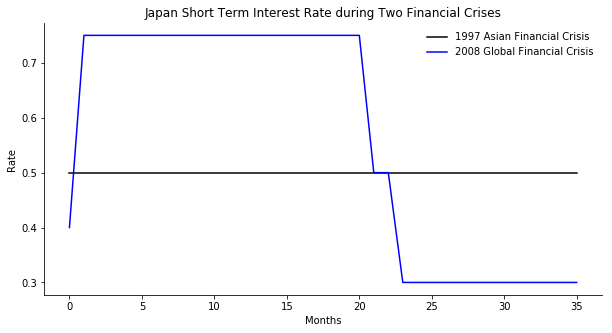

In [35]:
#monthly short-term interest rate for Japan: 
start_date_97=dt.datetime(1997,1,1)
end_date_97=dt.datetime(1999,12,31)
mask_97 = (jpn_ir_m.index>= start_date_97) & (jpn_ir_m.index <= end_date_97)
jpn_ir_97=jpn_ir_m.loc[mask_97]
jpn_ir_97=jpn_ir_97.reset_index()
start_date_08=dt.datetime(2007,1,1)
end_date_08=dt.datetime(2009,12,31)
mask_08 = (jpn_ir_m.index>= start_date_08) & (jpn_ir_m.index <= end_date_08)
jpn_ir_08=jpn_ir_m.loc[mask_08]
jpn_ir_08=jpn_ir_08.reset_index()
fig, ax = plt.subplots(figsize=(10,5)) 
ax.plot(jpn_ir_97.index, jpn_ir_97['Interest Rate'],color='black', label = '1997 Asian Financial Crisis')    
ax.plot(jpn_ir_08.index, jpn_ir_08['Interest Rate'],color='blue', label = '2008 Global Financial Crisis')
ax.set_ylabel('Rate')  
ax.set_xlabel('Months')                 
ax.set_title('Japan Short Term Interest Rate during Two Financial Crises')
ax.spines['right'].set_visible(False) 
ax.spines['top'].set_visible(False)
ax.legend(frameon=False)
fig.savefig('jpninterest.png')

In [36]:
print(jpn_ir_97.describe())
print(jpn_ir_08.describe())

       Interest Rate
count           36.0
mean             0.5
std              0.0
min              0.5
25%              0.5
50%              0.5
75%              0.5
max              0.5
       Interest Rate
count      36.000000
mean        0.563889
std         0.216006
min         0.300000
25%         0.300000
50%         0.750000
75%         0.750000
max         0.750000


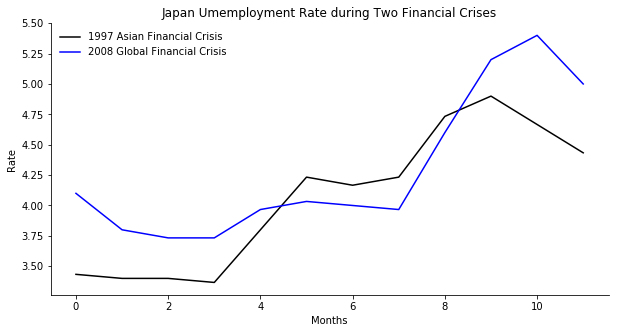

In [37]:
#monthly unemployment rate for Japan: 
start_date_97=dt.datetime(1997,1,1)
end_date_97=dt.datetime(1999,12,31)
mask_97 = (um.index>= start_date_97) & (um.index <= end_date_97)
jpn_um_97=um.loc[mask_97]
jpn_um_97=jpn_um_97.reset_index()
start_date_08=dt.datetime(2007,1,1)
end_date_08=dt.datetime(2009,12,31)
mask_08 = (um.index>= start_date_08) & (um.index <= end_date_08)
jpn_um_08=um.loc[mask_08]
jpn_um_08=jpn_um_08.reset_index()
fig, ax = plt.subplots(figsize=(10,5)) 
ax.plot(jpn_um_97.index, jpn_um_97['JUM'],color='black', label = '1997 Asian Financial Crisis')    
ax.plot(jpn_um_08.index, jpn_um_08['JUM'],color='blue', label = '2008 Global Financial Crisis')
ax.set_ylabel('Rate')  
ax.set_xlabel('Months')                 
ax.set_title('Japan Umemployment Rate during Two Financial Crises')
ax.spines['right'].set_visible(False) 
ax.spines['top'].set_visible(False)
ax.legend(frameon=False)
fig.savefig('jpnumrate.png')

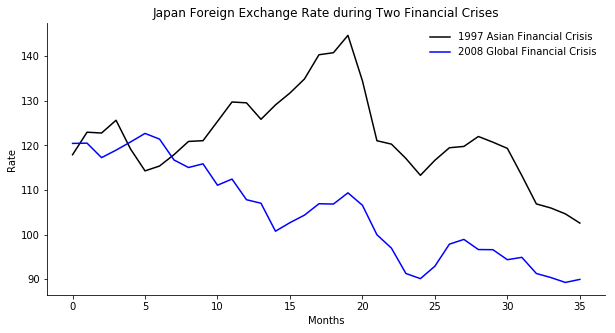

In [38]:
#monthly foreign exchange rate for China: 
start_date_97=dt.datetime(1997,1,1)
end_date_97=dt.datetime(1999,12,31)
mask_97 = (sk_fx_m.index>= start_date_97) & (sk_fx_m.index <= end_date_97)
jpn_fx_97=jpn_fx_m.loc[mask_97]
jpn_fx_97=jpn_fx_97.reset_index()
start_date_08=dt.datetime(2007,1,1)
end_date_08=dt.datetime(2009,12,31)
mask_08 = (jpn_fx_m.index>= start_date_08) & (jpn_fx_m.index <= end_date_08)
jpn_fx_08=jpn_fx_m.loc[mask_08]
jpn_fx_08=jpn_fx_08.reset_index()
fig, ax = plt.subplots(figsize=(10,5)) 
ax.plot(jpn_fx_97.index, jpn_fx_97['FX'],color='black', label = '1997 Asian Financial Crisis')    
ax.plot(jpn_fx_08.index, jpn_fx_08['FX'],color='blue', label = '2008 Global Financial Crisis')
ax.set_ylabel('Rate')  
ax.set_xlabel('Months')                 
ax.set_title('Japan Foreign Exchange Rate during Two Financial Crises')
ax.spines['right'].set_visible(False) 
ax.spines['top'].set_visible(False)
ax.legend(frameon=False)
fig.savefig('jpnfxrate.png')

In [39]:
print(jpn_fx_97.describe())
print(jpn_fx_08.describe())

               FX
count   36.000000
mean   121.875339
std      9.809670
min    102.584348
25%    116.970287
50%    120.807273
75%    126.659252
max    144.680000
               FX
count   36.000000
mean   104.914792
std     10.867026
min     89.267368
25%     96.185195
50%    105.467143
75%    115.249147
max    122.688571


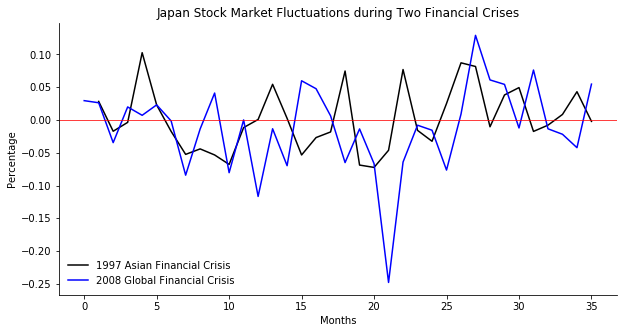

In [40]:
#monthly stock market fluctiations in Japan: 
start_date_97=dt.datetime(1997,1,1)
end_date_97=dt.datetime(1999,12,31)
mask_97 = (jpn_sm_m.index>= start_date_97) & (jpn_sm_m.index <= end_date_97)
jpn_sm_97=jpn_sm_m.loc[mask_97]
jpn_sm_97=jpn_sm_97.reset_index()
start_date_08=dt.datetime(2007,1,1)
end_date_08=dt.datetime(2009,12,31)
mask_08 = (jpn_sm_m.index>= start_date_08) & (jpn_sm_m.index <= end_date_08)
jpn_sm_08=jpn_sm_m.loc[mask_08]
jpn_sm_08=jpn_sm_08.reset_index()
fig, ax = plt.subplots(figsize=(10,5)) 
ax.plot(jpn_sm_97.index, jpn_sm_97['close_pct'],color='black', label = '1997 Asian Financial Crisis')    
ax.plot(jpn_sm_08.index, jpn_sm_08['close_pct'],color='blue', label = '2008 Global Financial Crisis')
ax.set_ylabel('Percentage')  
ax.set_xlabel('Months')                 
ax.set_title('Japan Stock Market Fluctuations during Two Financial Crises')
ax.spines['right'].set_visible(False) 
ax.spines['top'].set_visible(False)
ax.legend(frameon=False)
ax.axhline(y=0,color='red',linewidth=0.75)
fig.savefig('jpnsmprice.png')

In [41]:
print(jpn_sm_97.describe())
print(jpn_sm_08.describe())

              Close  close_pct
count     36.000000  35.000000
mean   16837.474408   0.001653
std     1829.650351   0.047821
min    13486.905895  -0.072376
25%    15490.215451  -0.029624
50%    16819.000674  -0.007889
75%    18194.485258   0.033292
max    20505.541016   0.102761
              Close  close_pct
count     36.000000  36.000000
mean   12821.128943  -0.011530
std     3504.401828   0.066435
min     7694.782586  -0.247988
25%     9678.587888  -0.047741
50%    13079.130013  -0.010050
75%    16291.779527   0.027124
max    18001.366164   0.129225


Since different countries might use foreign reserves differently, the next step that I will do is to regress foreign reserves on each monthly economic indicators, including exchange rate, stock market price, as well as short-term interest rate.

In [45]:
chn_rev_m=chn_rev.resample('m').mean()
chn_rev_m.reset_index(inplace=True)
chn_fx_m=chn_fx.resample('m').mean()
chn_fx_m.reset_index(inplace=True)
chn_ir_m=chn_ir.resample('m').mean()
chn_ir_m.reset_index(inplace=True)
chn_sm_m=chn_sm.resample('m').mean()
chn_sm_m.reset_index(inplace=True)
chn_sm_m=chn_sm_m.rename(columns={'Date':'DATE'})
#merge four dataframe: fx, short-term ir, reserves, and stock market price in one dataframe
chn=ft.reduce(ft.partial(pd.merge,on='DATE'), [chn_fx_m,chn_ir_m,chn_rev_m,chn_sm_m])
chn=chn.rename(columns={'Interest Rate':'chn_ir','FX':'chn_fx','Close':'chnsm_price'})
chn=chn.loc[(chn.DATE>= start_date_97) & (chn.DATE <= end_date_08)] 
a=[]
l=['chnsm_price','chn_fx','chn_ir'] #run the regressions in a loop
def reg(value):
    a='~reserves'
    b=value+a
    res=smf.ols(b, data=chn).fit(cov_type='HC3')
    print(res.summary())
    return res
for elm in l:
   reg(elm)

                            OLS Regression Results                            
Dep. Variable:            chnsm_price   R-squared:                       0.421
Model:                            OLS   Adj. R-squared:                  0.418
Method:                 Least Squares   F-statistic:                     77.15
Date:                Wed, 12 Dec 2018   Prob (F-statistic):           2.88e-15
Time:                        15:53:21   Log-Likelihood:                -1251.3
No. Observations:                 156   AIC:                             2507.
Df Residuals:                     154   BIC:                             2513.
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1271.8505     46.411     27.404      0.0

In [46]:
sk_rev_m=sk_rev.resample('m').mean()
sk_fx_m=sk_fx.resample('m').mean()
sk_ir_m=sk_ir.resample('m').mean()
sk_sm_m=sk_sm.resample('m').mean()
sk_rev_m.reset_index(inplace=True)
sk_fx_m.reset_index(inplace=True)
sk_ir_m.reset_index(inplace=True)
sk_sm_m.reset_index(inplace=True)
sk_sm_m=sk_sm_m.rename(columns={'Date':'DATE'})
#merge four dataframe: fx, short-term ir, reserves, and stock market price in one dataframe
sk=ft.reduce(ft.partial(pd.merge,on='DATE'), [sk_fx_m,sk_ir_m,sk_rev_m,sk_sm_m]) 
sk=sk.rename(columns={'Interest Rate':'sk_ir','FX':'sk_fx','Close':'sksm_price'}) 
sk=sk.loc[(sk.DATE>= start_date_97) & (sk.DATE <= end_date_08)] 
a=[]
l=['sksm_price','sk_fx','sk_ir']
def reg(value):
    a='~reserves'
    b=value+a
    res=smf.ols(b, data=sk).fit(cov_type='HC3')
    print(res.summary())
    return res
for elm in l:
   reg(elm)

                            OLS Regression Results                            
Dep. Variable:             sksm_price   R-squared:                       0.784
Model:                            OLS   Adj. R-squared:                  0.782
Method:                 Least Squares   F-statistic:                     470.4
Date:                Wed, 12 Dec 2018   Prob (F-statistic):           8.31e-48
Time:                        15:53:37   Log-Likelihood:                -1005.6
No. Observations:                 150   AIC:                             2015.
Df Residuals:                     148   BIC:                             2021.
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    232.2138     37.539      6.186      0.0

In [47]:
jpn_rev_m=jpn_rev.resample('m').mean()
jpn_fx_m=jpn_fx.resample('m').mean()
jpn_ir_m=jpn_ir.resample('m').mean()
jpn_sm_m=jpn_sm.resample('m').mean()
jpn_rev_m.reset_index(inplace=True)
jpn_fx_m.reset_index(inplace=True)
jpn_ir_m.reset_index(inplace=True)
jpn_sm_m.reset_index(inplace=True)
jpn_sm_m=jpn_sm_m.rename(columns={'Date':'DATE'})
#merge four dataframe: fx, short-term ir, reserves, and stock market price in one dataframe
jpn=ft.reduce(ft.partial(pd.merge,on='DATE'), [jpn_fx_m,jpn_ir_m,jpn_rev_m,jpn_sm_m])
jpn=jpn.rename(columns={'Interest Rate':'jpn_ir','FX':'jpn_fx','Close':'jpnsm_price'}) 
jpn=jpn.loc[(jpn.DATE>= start_date_97) & (jpn.DATE <= end_date_08)] 
a=[]
l=['jpnsm_price','jpn_fx','jpn_ir']
def reg(value):
    a='~reserves'
    b=value+a
    res=smf.ols(b, data=jpn).fit(cov_type='HC3')
    print(res.summary())
    return res
for elm in l:
   reg(elm)

                            OLS Regression Results                            
Dep. Variable:            jpnsm_price   R-squared:                       0.135
Model:                            OLS   Adj. R-squared:                  0.129
Method:                 Least Squares   F-statistic:                     28.74
Date:                Wed, 12 Dec 2018   Prob (F-statistic):           2.97e-07
Time:                        15:53:44   Log-Likelihood:                -1477.2
No. Observations:                 156   AIC:                             2958.
Df Residuals:                     154   BIC:                             2965.
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.612e+04    523.773     30.775      0.0